In [1]:
# create by claudio-i
# claudio-i@ace.me, claudioiturra@oceanografia.udec.cl
# january 22, 2026


The generated plot (shown at the top) combines data from the following sensors:

    VIIRS (N20, N21, Suomi-NPP): High-resolution thermal detections.

    MODIS (Terra, Aqua): Standard fire monitoring data.

Total fire detections processed: 9,562. The concentration of points indicates active fire zones, with the brighter/larger points representing higher intensity and energy release (FRP).

In [2]:
pwd

'/home/cl/Desktop/fire'

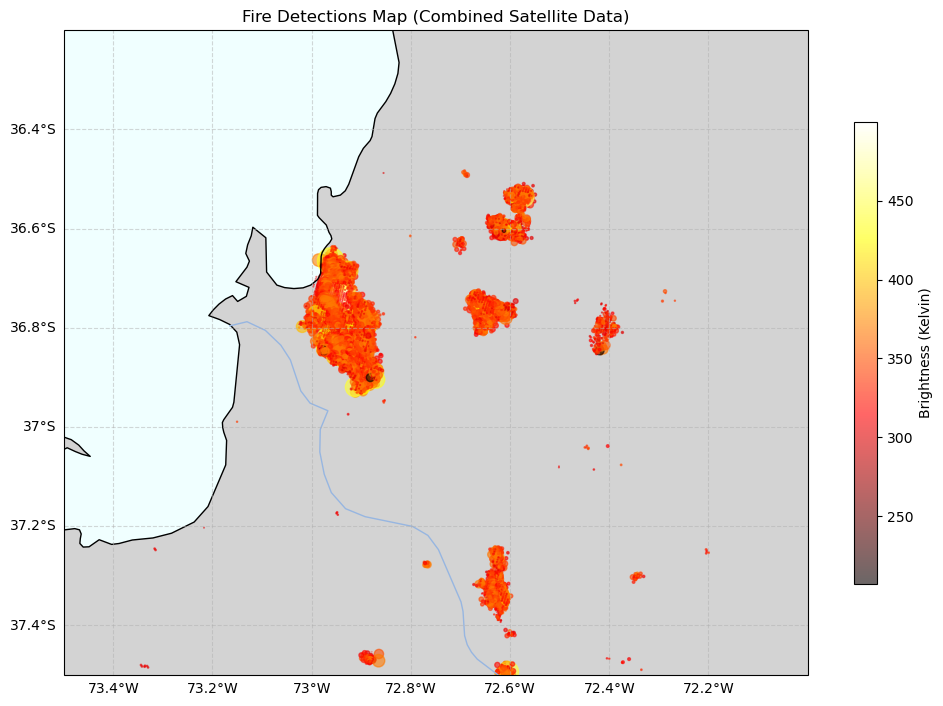

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# List of the uploaded files
files = [
    '/home/cl/Desktop/fire/DL_FIRE_J1V-C2_707678/fire_nrt_J1V-C2_707678.csv',
    '/home/cl/Desktop/fire/DL_FIRE_J2V-C2_707679/fire_nrt_J2V-C2_707679.csv',
    '/home/cl/Desktop/fire/DL_FIRE_M-C61_707676/fire_nrt_M-C61_707676.csv',
    '/home/cl/Desktop/fire/DL_FIRE_SV-C2_707680/fire_nrt_SV-C2_707680.csv'
]

# 1. Read and combine all data
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

# 2. Create the plot with a Cartopy projection
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# 3. Add geographic features
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.OCEAN, facecolor='azure')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.RIVERS)

# 4. Plot the fire data
# transform=ccrs.PlateCarree() tells cartopy the data is in Lat/Lon
scatter = ax.scatter(df['longitude'], df['latitude'],
                    c=df['brightness'], cmap='hot',
                    s=df['frp'] * 0.2, # Scaled size by Fire Radiative Power
                    alpha=0.6,
                    transform=ccrs.PlateCarree(),
                    label='Fire Detections')

# 5. Zoom into the specific region of the data
lat_margin = 1.0
lon_margin = 1.0
ax.set_extent([df['longitude'].min() - lon_margin, df['longitude'].max() + lon_margin,
               df['latitude'].min() - lat_margin, df['latitude'].max() + lat_margin], 
              crs=ccrs.PlateCarree())

# 6. Add labels and colorbar
plt.colorbar(scatter, label='Brightness (Kelvin)', shrink=0.6)
plt.title('Fire Detections Map (Combined Satellite Data)')

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
plt.xlim(-73.5, -72)
plt.ylim(-37.5, -36.2)

plt.show()

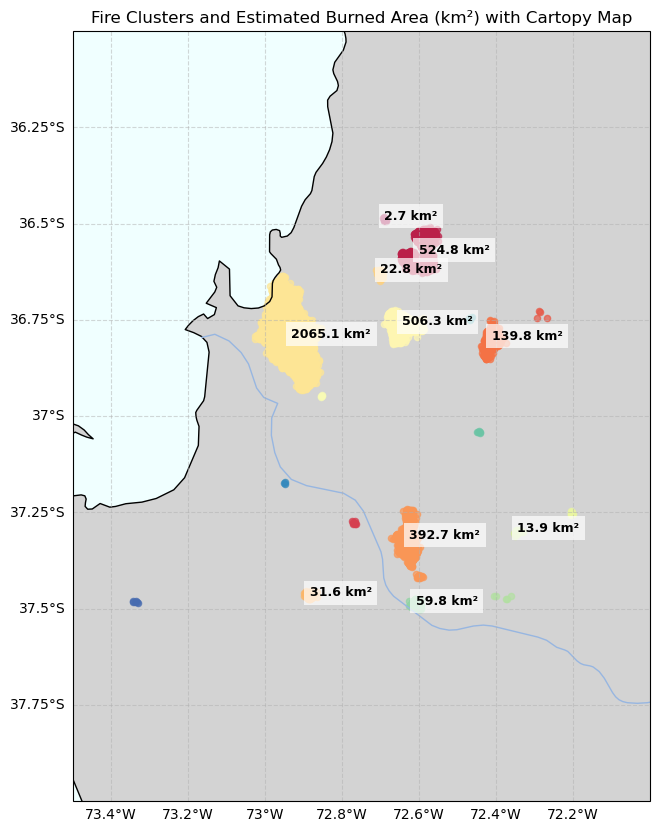

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import DBSCAN

# 1. Load and combine data
files = [
    '/home/cl/Desktop/fire/DL_FIRE_J1V-C2_707678/fire_nrt_J1V-C2_707678.csv',
    '/home/cl/Desktop/fire/DL_FIRE_J2V-C2_707679/fire_nrt_J2V-C2_707679.csv',
    '/home/cl/Desktop/fire/DL_FIRE_M-C61_707676/fire_nrt_M-C61_707676.csv',
    '/home/cl/Desktop/fire/DL_FIRE_SV-C2_707680/fire_nrt_SV-C2_707680.csv'
]
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 2. Filter to your requested region
df_roi = df[(df['latitude'] >= -38) & (df['latitude'] <= -36) & 
            (df['longitude'] >= -73.5) & (df['longitude'] <= -72)].copy()

# 3. Clustering (DBSCAN) and Area Calculation
# Group points within ~3.3km (0.03 degrees)
coords = df_roi[['longitude', 'latitude']].values
db = DBSCAN(eps=0.03, min_samples=3).fit(coords)
df_roi['cluster'] = db.labels_

# Approximate area using the pixel footprint (scan x track)
df_roi['pixel_area'] = df_roi['scan'] * df_roi['track']

# 4. Create Map with Cartopy
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add Geographic Background
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.RIVERS)

# 5. Plot each cluster and annotate area
unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1: continue # Skip noise
    
    cluster_data = df_roi[df_roi['cluster'] == k]
    total_area = cluster_data['pixel_area'].sum()
    
    # Plot cluster points
    ax.scatter(cluster_data['longitude'], cluster_data['latitude'], 
               color=tuple(col), s=20, alpha=0.7, 
               transform=ccrs.PlateCarree())
    
    # Annotate total area at the center of the cluster
    centroid_lon = cluster_data['longitude'].mean()
    centroid_lat = cluster_data['latitude'].mean()
    
    # Label significant clusters
    if len(cluster_data) > 10:
        ax.text(centroid_lon, centroid_lat, f"{total_area:.1f} km²", 
                transform=ccrs.PlateCarree(), fontsize=9, fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# 6. Set specific map limits
ax.set_extent([-73.5, -72, -38, -36], crs=ccrs.PlateCarree())

# 7. Add Gridlines and Labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title('Fire Clusters and Estimated Burned Area (km²) with Cartopy Map')
plt.show()

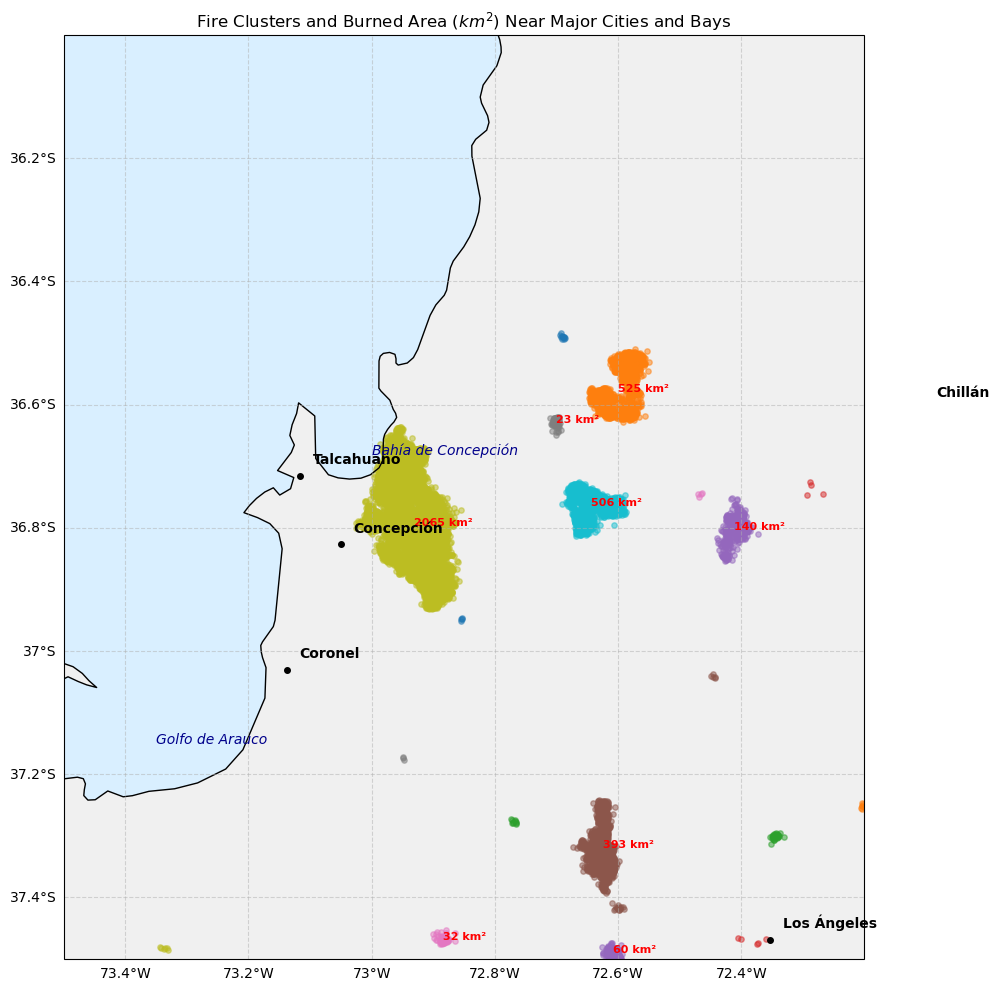

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import DBSCAN

# 1. Load and combine data
files = [
    '/home/cl/Desktop/fire/DL_FIRE_J1V-C2_707678/fire_nrt_J1V-C2_707678.csv',
    '/home/cl/Desktop/fire/DL_FIRE_J2V-C2_707679/fire_nrt_J2V-C2_707679.csv',
    '/home/cl/Desktop/fire/DL_FIRE_M-C61_707676/fire_nrt_M-C61_707676.csv',
    '/home/cl/Desktop/fire/DL_FIRE_SV-C2_707680/fire_nrt_SV-C2_707680.csv'
]
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 2. Filter to your requested region
df_roi = df[(df['latitude'] >= -38) & (df['latitude'] <= -36) & 
            (df['longitude'] >= -73.5) & (df['longitude'] <= -72)].copy()

# 3. Clustering and Area Calculation
coords = df_roi[['longitude', 'latitude']].values
db = DBSCAN(eps=0.03, min_samples=3).fit(coords)
df_roi['cluster'] = db.labels_
df_roi['pixel_area'] = df_roi['scan'] * df_roi['track']

# 4. Define Geographical Labels (Cities and Bays)
locations = [
    {"name": "Concepción", "lat": -36.827, "lon": -73.050, "type": "city"},
    {"name": "Chillán", "lat": -36.606, "lon": -72.103, "type": "city"},
    {"name": "Los Ángeles", "lat": -37.469, "lon": -72.353, "type": "city"},
    {"name": "Talcahuano", "lat": -36.716, "lon": -73.116, "type": "city"},
    {"name": "Coronel", "lat": -37.030, "lon": -73.138, "type": "city"},
    {"name": "Bahía de Concepción", "lat": -36.68, "lon": -73.00, "type": "bay"},
    {"name": "Golfo de Arauco", "lat": -37.15, "lon": -73.35, "type": "bay"}
]

# 5. Create Map
plt.figure(figsize=(14, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
ax.add_feature(cfeature.OCEAN, facecolor='#d9efff')
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# 6. Plot Clusters
unique_labels = set(db.labels_)
for k in unique_labels:
    if k == -1: continue
    cluster_data = df_roi[df_roi['cluster'] == k]
    total_area = cluster_data['pixel_area'].sum()
    
    ax.scatter(cluster_data['longitude'], cluster_data['latitude'], 
               s=15, alpha=0.5, transform=ccrs.PlateCarree())
    
    # Label fire area
    if len(cluster_data) > 50:
        centroid_lon = cluster_data['longitude'].mean()
        centroid_lat = cluster_data['latitude'].mean()
        ax.text(centroid_lon, centroid_lat, f"{total_area:.0f} km²", 
                transform=ccrs.PlateCarree(), color='red', fontsize=8, weight='bold')

# 7. Add City and Bay Names
for loc in locations:
    if loc['type'] == 'city':
        # Draw a small dot for the city
        ax.plot(loc['lon'], loc['lat'], 'ko', markersize=4, transform=ccrs.PlateCarree())
        ax.text(loc['lon'] + 0.02, loc['lat'] + 0.02, loc['name'], 
                transform=ccrs.PlateCarree(), fontsize=10, weight='bold', color='black')
    else:
        # Style for bays (italic and blue)
        ax.text(loc['lon'], loc['lat'], loc['name'], 
                transform=ccrs.PlateCarree(), fontsize=10, style='italic', color='darkblue')

# 8. Final Formatting
ax.set_extent([-73.5, -72.2, -37.5, -36], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title('Fire Clusters and Burned Area ($km^2$) Near Major Cities and Bays')
plt.show()

# Concepcion

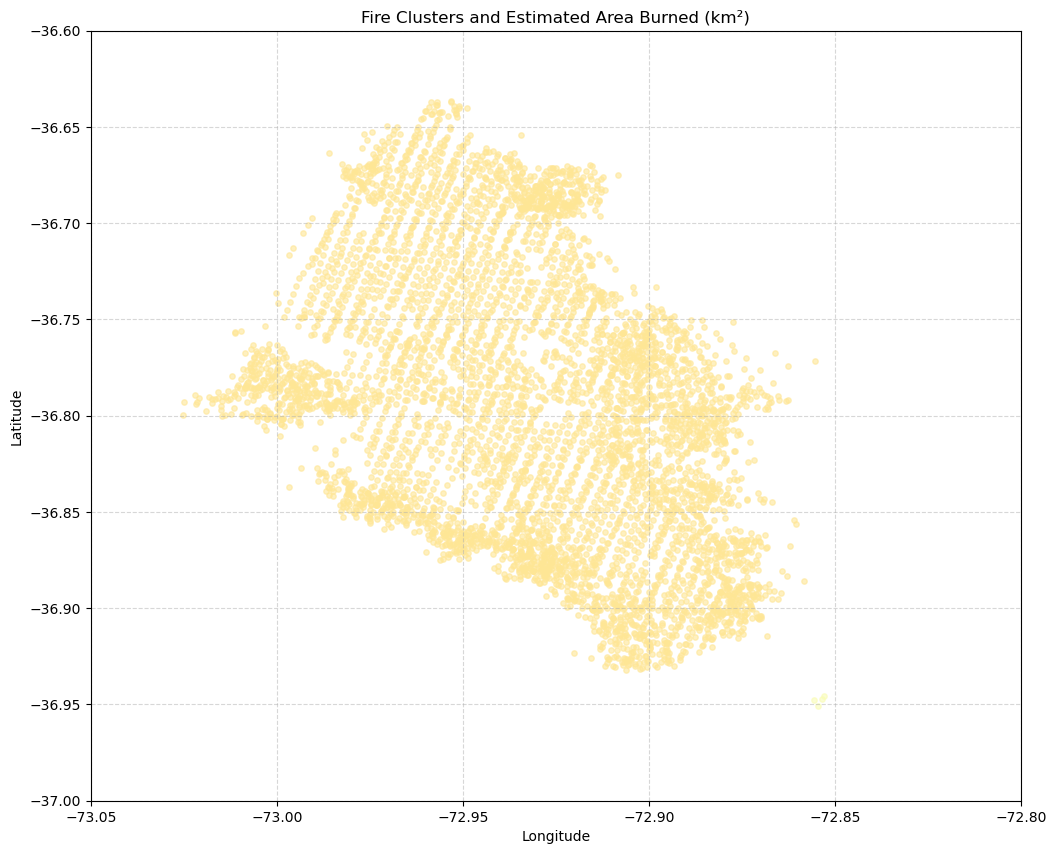

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# 1. Load and combine data

files = [
    '/home/cl/Desktop/fire/DL_FIRE_J1V-C2_707678/fire_nrt_J1V-C2_707678.csv',
    '/home/cl/Desktop/fire/DL_FIRE_J2V-C2_707679/fire_nrt_J2V-C2_707679.csv',
    '/home/cl/Desktop/fire/DL_FIRE_M-C61_707676/fire_nrt_M-C61_707676.csv',
    '/home/cl/Desktop/fire/DL_FIRE_SV-C2_707680/fire_nrt_SV-C2_707680.csv'
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 2. Filter to the specific region
df_roi = df[(df['latitude'] >= -38) & (df['latitude'] <= -36) & 
            (df['longitude'] >= -73.5) & (df['longitude'] <= -72)].copy()

# 3. Perform Clustering
# eps=0.03 is roughly 3.3km. Points within this range are grouped.
coords = df_roi[['longitude', 'latitude']].values
db = DBSCAN(eps=0.03, min_samples=3).fit(coords)
df_roi['cluster'] = db.labels_

# 4. Calculate Area (sum of pixel footprint: scan * track)
df_roi['pixel_area'] = df_roi['scan'] * df_roi['track']

plt.figure(figsize=(12, 10))
unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1: continue # Skip noise points for area annotation
    
    cluster_data = df_roi[df_roi['cluster'] == k]
    total_area = cluster_data['pixel_area'].sum()
    
    # Plotting
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                color=tuple(col), s=15, alpha=0.6)
    

# Formatting
plt.xlim(-73.05, -72.8)
plt.ylim(-37, -36.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fire Clusters and Estimated Area Burned (km²)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.show()

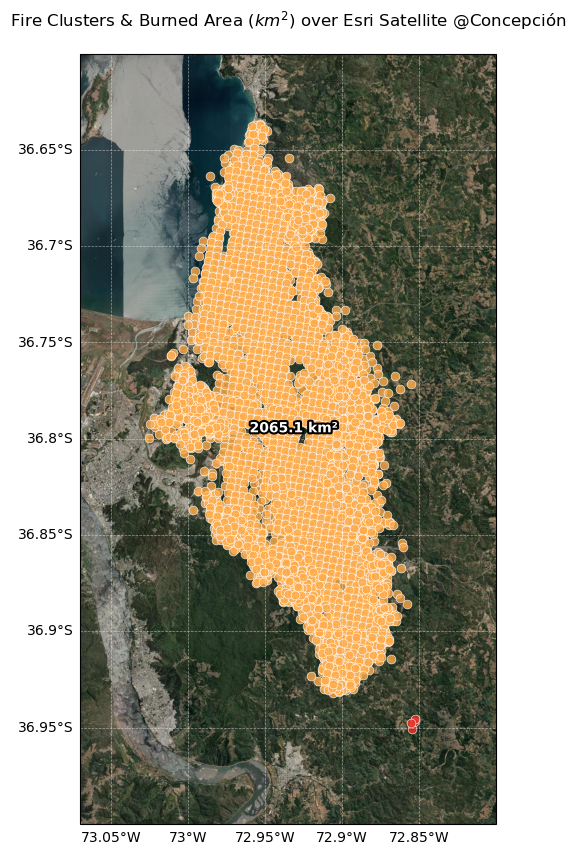

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.mpl.ticker as cticker
from matplotlib import patheffects
from sklearn.cluster import DBSCAN

# 1. Define Esri satellite tiles class
class EsriWorldImagery(cimgt.GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        return (
            "https://services.arcgisonline.com/ArcGIS/rest/services/"
            f"World_Imagery/MapServer/tile/{z}/{y}/{x}"
        )

# 2. Load and combine fire data
files = [
    '/home/cl/Desktop/fire/DL_FIRE_J1V-C2_707678/fire_nrt_J1V-C2_707678.csv',
    '/home/cl/Desktop/fire/DL_FIRE_J2V-C2_707679/fire_nrt_J2V-C2_707679.csv',
    '/home/cl/Desktop/fire/DL_FIRE_M-C61_707676/fire_nrt_M-C61_707676.csv',
    '/home/cl/Desktop/fire/DL_FIRE_SV-C2_707680/fire_nrt_SV-C2_707680.csv'
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 3. Filter to the Study Area ROI
# Using the specific limits provided in your scatter code
lon_min, lon_max = -73.07, -72.8
lat_min, lat_max = -37.0, -36.6

df_roi = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) & 
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)].copy()

# 4. Perform Clustering and Area Calculation
if not df_roi.empty:
    coords = df_roi[['longitude', 'latitude']].values
    # eps=0.01 is ~1.1km; suitable for this zoomed extent
    db = DBSCAN(eps=0.01, min_samples=3).fit(coords)
    df_roi['cluster'] = db.labels_
    df_roi['pixel_area'] = df_roi['scan'] * df_roi['track']

# 5. Initialize Map Figure
tiler = EsriWorldImagery()
plt.figure(figsize=(10, 10), dpi=100)
ax = plt.axes(projection=tiler.crs)

# Set the map extent
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add satellite imagery (Zoom level 13 provides good detail for this extent)
ax.add_image(tiler, 13)

# 6. Overlay Fire Data
if not df_roi.empty:
    unique_labels = set(df_roi['cluster'])
    # Fiery color palette
    colors = [plt.cm.YlOrRd(each) for each in np.linspace(0.4, 1, len(unique_labels))]
    
    # Text effect for readability over satellite imagery
    effects = [patheffects.withStroke(linewidth=3, foreground='black')]

    for k, col in zip(unique_labels, colors):
        if k == -1: continue # Skip noise points
        
        cluster_data = df_roi[df_roi['cluster'] == k]
        total_area = cluster_data['pixel_area'].sum()
        
        # Plot fire points (transform=ccrs.PlateCarree() is vital)
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                   color=tuple(col), s=40, alpha=0.8, edgecolors='white', 
                   linewidth=0.5, transform=ccrs.PlateCarree())
        
        # Annotate estimated burned area for significant clusters
        if len(cluster_data) > 10:
            centroid_lon = cluster_data['longitude'].mean()
            centroid_lat = cluster_data['latitude'].mean()
            ax.text(centroid_lon, centroid_lat, f"{total_area:.1f} km²", 
                    transform=ccrs.PlateCarree(), color='white', weight='bold', 
                    fontsize=10, path_effects=effects, ha='center')

# 7. Gridlines and Labels
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=0.5, color="white", alpha=0.5, linestyle="--",
)
gl.xformatter = cticker.LongitudeFormatter()
gl.yformatter = cticker.LatitudeFormatter()
gl.top_labels = False
gl.right_labels = False

plt.title('Fire Clusters & Burned Area ($km^2$) over Esri Satellite @Concepción', pad=20)
plt.show()
     


Reading files...
Creating animation with 101 frames...


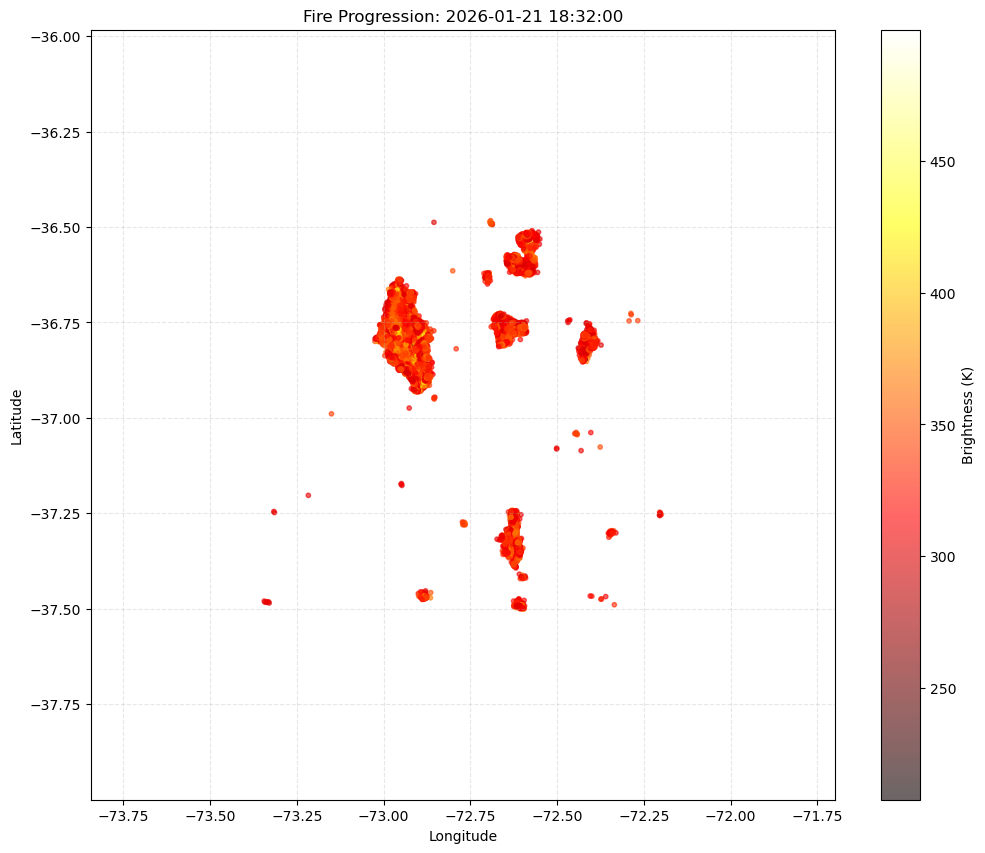

Animation saved as fire_progression.gif


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# 1. Load and Concatenate Data
files = [
    '/home/cl/Desktop/fire/DL_FIRE_J1V-C2_707678/fire_nrt_J1V-C2_707678.csv',
    '/home/cl/Desktop/fire/DL_FIRE_J2V-C2_707679/fire_nrt_J2V-C2_707679.csv',
    '/home/cl/Desktop/fire/DL_FIRE_M-C61_707676/fire_nrt_M-C61_707676.csv',
    '/home/cl/Desktop/fire/DL_FIRE_SV-C2_707680/fire_nrt_SV-C2_707680.csv'
]

print("Reading files...")
df_list = [pd.read_csv(f) for f in files]
df = pd.concat(df_list, ignore_index=True)

# 2. Create a clean Datetime column and sort
# acq_time is HHMM (e.g., 552 -> 05:52)
df['datetime'] = pd.to_datetime(
    df['acq_date'] + ' ' + df['acq_time'].astype(str).str.zfill(4), 
    format='%Y-%m-%d %H%M'
)
df = df.sort_values('datetime')
unique_times = df['datetime'].unique()

# 3. Setup the Figure for Animation
fig, ax = plt.subplots(figsize=(12, 10))

# Pre-calculate limits to keep the frame steady
ax.set_xlim(df['longitude'].min() - 0.5, df['longitude'].max() + 0.5)
ax.set_ylim(df['latitude'].min() - 0.5, df['latitude'].max() + 0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.3)

# Initialize scatter plot (empty)
# vmin/vmax ensure the color scale stays consistent throughout the animation
scat = ax.scatter([], [], c=[], cmap='hot', s=10, alpha=0.6, 
                  vmin=df['brightness'].min(), vmax=df['brightness'].max())

plt.colorbar(scat, label='Brightness (K)')
title = ax.set_title('Fire Progression')

# 4. Animation Function
def update(frame):
    current_time = unique_times[frame]
    # Filter data up to the current timestamp
    data_so_far = df[df['datetime'] <= current_time]
    
    # Update scatter plot points and colors
    scat.set_offsets(data_so_far[['longitude', 'latitude']])
    scat.set_array(data_so_far['brightness'])
    
    # Update title with the current date and time
    title.set_text(f'Fire Progression: {current_time}')
    return scat, title

# 5. Create and Save Animation
print(f"Creating animation with {len(unique_times)} frames...")
ani = animation.FuncAnimation(fig, update, frames=len(unique_times), 
                              interval=150, blit=True)

# To save as a GIF (requires 'pillow' library: pip install pillow)
ani.save('fire_progression.gif', writer='pillow')

# To save as an MP4 (requires 'ffmpeg' installed on your system)
# ani.save('fire_progression.mp4', writer='ffmpeg', fps=10)

plt.show()
print("Animation saved as fire_progression.gif")

Creating animation...


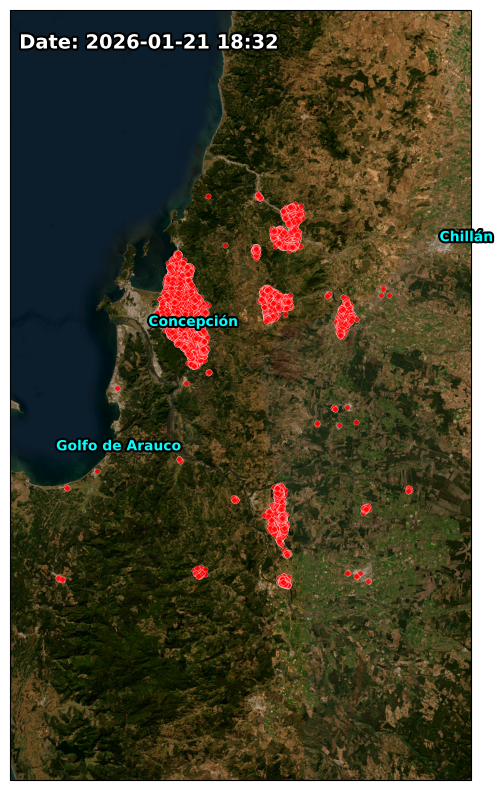

Process Complete. File saved as fire_progression_cartopy.gif


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib import patheffects

# 1. Define Esri Satellite Tiles
class EsriWorldImagery(cimgt.GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        return (f"https://services.arcgisonline.com/ArcGIS/rest/services/"
                f"World_Imagery/MapServer/tile/{z}/{y}/{x}")

# 2. Load and Concatenate Data
files = [
    '/home/cl/Desktop/fire/DL_FIRE_J1V-C2_707678/fire_nrt_J1V-C2_707678.csv',
    '/home/cl/Desktop/fire/DL_FIRE_J2V-C2_707679/fire_nrt_J2V-C2_707679.csv',
    '/home/cl/Desktop/fire/DL_FIRE_M-C61_707676/fire_nrt_M-C61_707676.csv',
    '/home/cl/Desktop/fire/DL_FIRE_SV-C2_707680/fire_nrt_SV-C2_707680.csv'
]

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 3. Clean Datetime and Sort
# Combine date and time (padding time to 4 digits for HHMM)
df['datetime'] = pd.to_datetime(
    df['acq_date'] + ' ' + df['acq_time'].astype(str).str.zfill(4), 
    format='%Y-%m-%d %H%M'
)
df = df.sort_values('datetime')
unique_times = df['datetime'].unique()

# 4. Setup Map and Figure
tiler = EsriWorldImagery()
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=tiler.crs)

# Zoom into the study area (Concepción/Biobío)
extent = [-73.5, -72.0, -38.0, -36.0]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add the satellite background once (Level 11 is a good balance of detail/speed)
ax.add_image(tiler, 11)

# Initialize the fire points (empty) and time label
scat = ax.scatter([], [], color='red', s=15, edgecolors='white', 
                  linewidth=0.2, alpha=0.8, transform=ccrs.PlateCarree())

# Text effects for readability
effects = [patheffects.withStroke(linewidth=3, foreground='black')]
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='white', 
                    fontsize=14, weight='bold', path_effects=effects)

# 5. Add Static Geographic Labels
locations = [
    {"name": "Concepción", "lat": -36.827, "lon": -73.050},
    {"name": "Chillán", "lat": -36.606, "lon": -72.103},
    {"name": "Golfo de Arauco", "lat": -37.15, "lon": -73.35}
]
for loc in locations:
    ax.text(loc['lon'], loc['lat'], loc['name'], transform=ccrs.PlateCarree(),
            color='cyan', fontsize=10, weight='bold', path_effects=effects)

# 6. Animation Function
def update(frame):
    current_time = unique_times[frame]
    # Filter data up to the current timestamp
    data_so_far = df[df['datetime'] <= current_time]
    
    # Update points on map
    scat.set_offsets(data_so_far[['longitude', 'latitude']])
    
    # Update clock label
    time_text.set_text(f"Date: {current_time.strftime('%Y-%m-%d %H:%M')}")
    return scat, time_text

# 7. Create and Save the Animation
print("Creating animation...")
ani = animation.FuncAnimation(fig, update, frames=len(unique_times), 
                              interval=100, blit=True)

# Save as GIF
ani.save('fire_progression_cartopy.gif', writer='pillow')

plt.show()
print("Process Complete. File saved as fire_progression_cartopy.gif")